In [1]:
import os, sys
sys.path.append(os.path.abspath("../src"))

import numpy as np
import scipy as sp
import qutip
import time as timer
import matplotlib.pyplot as plt

import optimization, simulation, utils, visualization

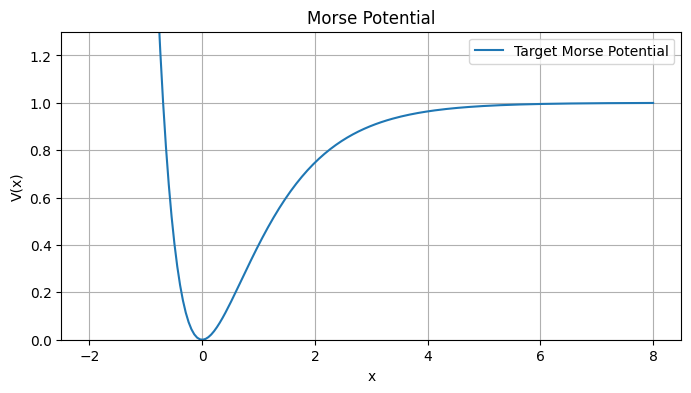

In [2]:
morse_potential = utils.MorsePotential(
    de = 1.0,
    b = 1.0,
    x0 = 0.0
)

morse_potential.plot_potential()

In [3]:
backend = utils.Gates(dim = 25)

time = 1.0

depth = 7

morse_hamiltonian = backend.m_ham_full(morse_potential)
expanded_morse_hamiltonain = backend.m_ham_expansion_full(morse_potential, 4)

In [4]:
init_qubit_state = qutip.basis(2,0)
init_qumode_state = qutip.coherent(backend.dim, 1.0)
full_init_state = qutip.tensor(init_qubit_state, init_qumode_state)

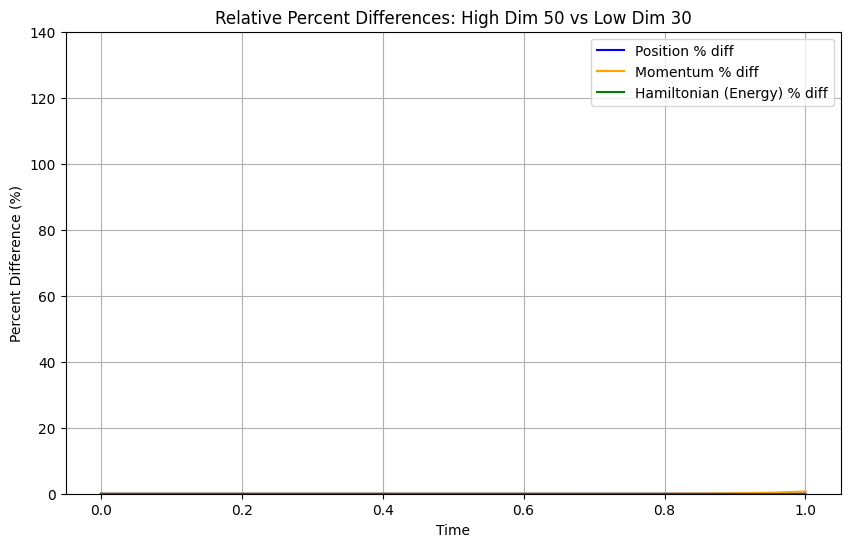

In [ ]:
# Determining the best dimension to use for testing
# Extra Information:
#   Only the qumode space is being looked at

# 1. choose the initial state to evolve and create it in the high dimension
high_dim = 50
high_init_qum_state = qutip.coherent(high_dim, 1.0)

# 2. create the position, momentum, and hamiltonian matrices for a high dimension
high_backend = utils.Gates(dim = high_dim)
high_x = qutip.Qobj(high_backend.x_op)
high_p = qutip.Qobj(high_backend.p_op)
high_ham = qutip.Qobj(high_backend.m_ham(morse_potential))

# 3. evolve the initial state in a high dimension at different times
times = np.linspace(0, 1, 100)
high_states = []
for t in times:
    evo_matrix_at_t = qutip.Qobj(high_backend.m_evo(morse_potential, t))
    high_states.append(evo_matrix_at_t * high_init_qum_state)

# 4. calculate the expectation value of position, momentum, and hamiltonian operators from the evolved state at different times
x_exp = np.real(np.array(qutip.expect(high_x, high_states)))
p_exp = np.real(np.array(qutip.expect(high_p, high_states)))
h_exp = np.real(np.array(qutip.expect(high_ham, high_states)))
h_avg = np.average(h_exp)

# 5. repeat steps 1-4 for lower dimensions
test_dims = [30] # to be changed for different dimensions we want to test
test_p_exps = []
test_x_exps = []
test_h_exps = []
test_h_avgs = []

for test_dim in test_dims:
    test_init_qum_state = qutip.coherent(test_dim, 1.0)

    dim_backend = utils.Gates(dim = test_dim)
    test_x = qutip.Qobj(dim_backend.x_op)
    test_p = qutip.Qobj(dim_backend.p_op)
    test_ham = qutip.Qobj(dim_backend.m_ham(morse_potential))

    test_states = []

    for t in times:
        test_evo_matrix_at_t = qutip.Qobj(dim_backend.m_evo(morse_potential, t))
        test_states.append(test_evo_matrix_at_t * test_init_qum_state)

    test_x_exp = np.real(np.array(qutip.expect(test_x, test_states)))
    test_p_exp = np.real(np.array(qutip.expect(test_p, test_states)))
    test_h_exp = np.real(np.array(qutip.expect(test_ham, test_states)))
    test_h_avg = np.average(test_h_exp)

    test_x_exps.append(test_x_exp)
    test_p_exps.append(test_p_exp)
    test_h_exps.append(test_h_exp)
    test_h_avgs.append(test_h_avg)

p_exp[0] = 1e-12
for k in range(len(test_p_exps)):
    test_p_exps[k][0] = 1e-12

# 6. compare the difference over the times (relative percent differences)
x_percent_diffs = []
p_percent_diffs = []
h_percent_diffs = []
h_avg_percent_diffs = []

for i in range(len(test_h_avgs)):
    percent_diff_x = 100 * np.abs(x_exp - test_x_exps[i]) / np.abs((x_exp + test_x_exps[i]) / 2)
    
    percent_diff_p = 100 * np.abs(p_exp - test_p_exps[i]) / np.abs((p_exp + test_p_exps[i]) / 2)

    percent_diff_h = 100 * np.abs(h_exp - test_h_exps[i]) / np.abs((h_exp + test_h_exps[i]) / 2)
    
    percent_diff_avg_h = 100 * np.abs(h_avg - test_h_avgs[i]) / np.abs((h_avg + test_h_avgs[i]) / 2)
    
    x_percent_diffs.append(percent_diff_x)
    p_percent_diffs.append(percent_diff_p)
    h_percent_diffs.append(percent_diff_h)
    h_avg_percent_diffs.append(percent_diff_avg_h)

# 7. plot
x_diff = x_percent_diffs[0]
p_diff = p_percent_diffs[0]
h_diff = h_percent_diffs[0]

plt.figure(figsize=(10, 6))
plt.plot(times, x_diff, label='Position % diff', color='blue')
plt.plot(times, p_diff, label='Momentum % diff', color='orange')
plt.plot(times, h_diff, label='Hamiltonian (Energy) % diff', color='green')

plt.xlabel('Time')
plt.ylabel('Percent Difference (%)')
plt.title(f'Relative Percent Differences: High Dim {high_dim} vs Low Dim {test_dims[0]}')
plt.legend()
plt.grid(True)
plt.ylim(0, 140)
plt.show()

In [ ]:
true_results = simulation.simulate(
    init_state = full_init_state,
    full_hamiltonian = morse_hamiltonian,
    end_time = 1.0,
    backend = backend
)

visualization.plot_wigner_fucntion(true_results, 1, 6)

In [ ]:
expansion_results = simulation.simulate(
    init_state = full_init_state,
    full_hamiltonian = expanded_morse_hamiltonain,
    end_time = 1.0,
    backend = backend
)

visualization.plot_wigner_fucntion(expansion_results, 1, 6)

In [ ]:
def sequence_function(init_params, init_state, depth, times):
    
    states = []

    for n in range(0, len(times)):

        U_total = np.kron(backend.I_q, backend.I_o)

        for layer in range(0, depth):

            chi = init_params[0]
            alpha_real = init_params[1+4*layer]
            alpha_imag = init_params[2+4*layer]
            theta = init_params[3+4*layer]
            phi = init_params[4+4*layer]

            conr = backend.c_r(omega = 0.0, chi = chi, t = times[n] / depth)
            disp = backend.cv_d_full(alpha_real + 1j*alpha_imag)
            qrot = backend.q_xy_r_full(theta, phi)

            U_layer = disp @ qrot @ conr
            U_total = U_layer @ U_total

        U_total = qutip.Qobj(U_total, dims = [[2, backend.dim], [2, backend.dim]])
        state_for_time = U_total * init_state
        states.append(state_for_time)

    result = {}
    result['states'] = states
    result['times'] = times

    return result

def cost_function(params, depth, init_state, times, target_results):

    global best_params, best_cost, curr_iter

    init_params = []

    chi = params[0]
    alpha_reals = params[1::4]
    alpha_imags = params[2::4]
    thetas = params[3::4]
    phis = params[4::4]

    init_params = [chi] + init_params

    for i in range(depth):
        init_params = init_params + [alpha_reals[i], alpha_imags[i], thetas[i], phis[i]]

    result = sequence_function(init_params, init_state, depth, times)

    fidelities = []

    for i in range(len(times)):
        synth_result = result['states'][i]
        target_result = target_results[i]
        fidelities.append(qutip.fidelity(synth_result, target_result))
    
    cost = 100 * (1 - np.sum(fidelities) / len(fidelities))
    curr_iter += 1 
    print(f"Current cost: {cost:.6f}; Iteration: {curr_iter}")

    if cost < best_cost:
        best_cost = cost
        best_params = params.copy()
        #print(f"New best cost: {best_cost:.6f} with params: {best_params}")

    return cost

best_cost = np.inf
best_params = None
times = np.linspace(1, 1, 1)
target_results = [ (qutip.Qobj(backend.m_evo_expansion_full(morse_potential, 4, t), dims = [[2, backend.dim], [2, backend.dim]]) * full_init_state) for t in times]

start_params = [0.5] * (1 + 4 * depth)


print(start_params)

In [ ]:
test_results = {}
test_results['states'] = target_results
test_results['times'] = times
visualization.plot_wigner_fucntion(test_results, 1, 1)

In [ ]:
curr_iter = 0

target_cost = 1.3
time_limit = 120

start_time = timer.time()

def fidelity_limited_callback(xk, *args):
    global best_cost, best_params

    curr_cost = cost_function(xk, depth, full_init_state, times, target_results)
    elapsed = timer.time() - start_time

    # Track progress
    if curr_cost < best_cost:
        best_cost = curr_cost
        best_params = xk.copy()
        print(f"⏱️ {elapsed:.2f}s | Best cost so far: {best_cost:.6f}")

    # --- Stop conditions ---
    if curr_cost <= target_cost:
        print(f"🎯 Target fidelity reached in {elapsed:.2f} seconds.")
        raise KeyboardInterrupt  # Graceful stop

    if elapsed >= time_limit:
        print(f"⏰ Time limit of {time_limit/60:.1f} minutes reached.")
        raise KeyboardInterrupt  # Graceful stop

try:
    theresult = sp.optimize.minimize(
        cost_function,
        start_params,
        args=(depth, full_init_state, times, target_results),
        method='trust-constr',
        options={'maxiter': 100000},
        callback=fidelity_limited_callback
    )
except KeyboardInterrupt:
    elapsed = timer.time() - start_time
    print(f"⏱️ Total time: {elapsed:.2f} seconds.")

In [ ]:
# Test the different optimizaiton methods
# Gate Depth: 7, Optimizing for Expansion order 4, time = 1.0
# Time to reach under 1.3 infidelity (in seconds) (tiem limit 120s)
# COBYLA: time limit reached
# BFGS: 15.97, 15.74, 20.18, 16.41, 16.31
# Nelder-Mead: time limit reached
# Powell: time limit reached
# CG: time limit reached
# L-BFGS-B: fidelity not reached
# TNC: fidelity not reached
# COBYQA: time limit reached
# SLSQP: 13.77, 14.22, 14.48, 13.71, 14.56
# trust-constr: time limit reached

In [ ]:
# Data (seconds to reach target fidelity)
data = {
    "COBYLA": None,  # time limit reached
    "BFGS": [15.97, 15.74, 20.18, 16.41, 16.31],
    "Nelder-Mead": None,
    "Powell": None,
    "CG": None,
    "L-BFGS-B": None,
    "TNC": None,
    "COBYQA": None,
    "SLSQP": [13.77, 14.22, 14.48, 13.71, 14.56],
    "trust-constr": None
}

optimizers = []
avg_times = []
timeouts = []

for name, times in data.items():
    if not times:
        avg_times.append(None)
        timeouts.append(True)
    else:
        avg_times.append(np.mean(times))
        timeouts.append(False)
    optimizers.append(name)

plt.figure(figsize=(10, 5))

# Bars for those that completed
for i, (opt, avg, timeout) in enumerate(zip(optimizers, avg_times, timeouts)):
    if timeout:
        plt.bar(opt, 120, color="lightgray", hatch="//", label="Time limit" if i == 0 else "")
    else:
        plt.bar(opt, avg, color="skyblue", label="Completed" if i == 0 else "")
        # Add text label above the bar
        plt.text(opt, avg + 2, f"{avg:.2f}s", ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.ylabel("Time to reach target fidelity (s)")
plt.title("Optimizer Performance Comparison")
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 130)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
print(theresult.x)

# Best (Degree 2): [ 1.99958795e+00 -4.97360726e-04  1.47953138e-04  3.55508759e-05 9.42402483e-01]

#Best (Visual) (Degree 3):
#[ 3.43014598e+00  
#  1.28744548e+00  8.09414273e-01  1.57111163e+00 1.14943384e+00
#  1.99033958e+00  2.18180068e+00  1.03832558e+00 1.57034123e+00
#  1.71989341e+00  9.39525384e-01  1.57019037e+00 1.46645227e+00
#  1.15766694e+00  9.46882413e-01  7.85019210e-01 -6.70027693e-04
#  9.12451376e-01  9.59394807e-01  7.85387673e-01 -1.56837298e-04
#  1.03518314e+00  9.76239959e-01  1.57015164e+00  1.27487903e+00

#Best (Fidelity) (Degree 3):
#[ 3.57423062e+00  
#  1.34788728e+00  8.13437272e-01  1.57078961e+00  1.14398511e+00  
#  2.11794212e+00  2.03172496e+00  1.04112484e+00  1.57077158e+00  
#  2.81643008e+00  1.19185338e+00  1.57057950e+00  1.47838363e+00 
#  -3.90193434e-02  1.01425253e+00 7.85336458e-01  6.28214629e-06  
#  7.01502743e-01  1.11095769e+00  7.85414036e-01  6.37967817e-05  
#  1.43177153e+00  5.35955295e-01  1.57072309e+00  1.28103601e+00

# Best (Fidelity) (Degree 4):
#[ 5.51097519e+00  2.60772639e+00  6.35787408e-01  1.57078818e+00
#  8.61138672e-01  1.92452521e+00  1.58568355e+00  1.09986004e+00
#  1.57062878e+00  2.90787466e+00  1.76697534e-01  1.57153486e+00
#  1.49412214e+00 -1.72877030e-01  1.16315157e+00  7.85415322e-01
# -8.28377818e-05  9.62719240e-01  1.05881175e+00  7.85528545e-01
#  5.73149118e-05  1.77558518e+00  7.34073483e-01  1.57083763e+00
#  2.25158970e+00]



In [ ]:
results_to_viz = sequence_function(theresult.x, full_init_state, depth, times)
visualization.plot_wigner_fucntion(results_to_viz, 1, 1)

In [ ]:
inits_to_viz = sequence_function(start_params, full_init_state, depth, times)
visualization.plot_wigner_fucntion(inits_to_viz, 1, 1)